<a href="https://colab.research.google.com/github/GokayToga/ThermalNet/blob/main/ThermalNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ThermalNet by GBC&Co.**

## Libraries

In [ ]:
!pip install PyDrive
!pip install gdown
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.151.0
    Uninstalling google-api-python-client-2.151.0:
      Successfully uninstalled google-api-python-client-2.151.0


In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing & Augmentation

### Data Preprocessing

#### 1. Define the Dataset Class

This section involves defining the ThermalRGBDataset class, which handles the loading and preprocessing of RGB and thermal image pairs. Key points:
- _load_pairs(): Loads pairs of thermal and visible images by matching filenames.
- \_\_len\_\_: Returns the total number of paired images in the dataset.
- \_\_getitem\_\_: Loads and preprocesses RGB and thermal images by resizing, normalizing, and applying transformations.


In [ ]:
# Define rgb_augmentation
def rgb_augmentation(pil_image):
    """
    Apply random augmentations to an RGB image using torchvision transforms.
    """
    augmentation = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
    ])
    return augmentation(pil_image)

# Define add_noise
def add_noise(image):
    """
    Add random Gaussian noise to a thermal image.
    """
    mean = 0
    stddev = 0.05
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Your Dataset class and DataLoader logic remain unchanged

class ThermalRGBDataset(Dataset):
    def __init__(self, base_dir, condition, img_size=(640, 480), augment=False, transform=None):
        """
        Initialize the dataset.

        Args:
            base_dir (str): Path to the dataset root directory.
            condition (str): 'cloudy' or 'sunny'.
            img_size (tuple): Target image size (width, height).
            augment (bool): Whether to apply augmentations.
            transform (callable): Additional transforms to apply.
        """
        self.base_dir = base_dir
        self.condition = condition
        self.img_size = img_size
        self.augment = augment
        self.transform = transform
        self.pairs = self._load_pairs()

    def _load_pairs(self):
        """
        Load paired thermal and visible images.
        """
        pairs = []
        condition_path = os.path.join(self.base_dir, self.condition)
        scenes = [os.path.join(condition_path, scene) for scene in os.listdir(condition_path) if scene.startswith("scene")]
        for scene in scenes:
            thermal_path = os.path.join(scene, "thermal/images")
            visible_path = os.path.join(scene, "visible/images")

            thermal_files = sorted(os.listdir(thermal_path))
            visible_files = sorted(os.listdir(visible_path))
            for thermal, visible in zip(thermal_files, visible_files):
                pairs.append((os.path.join(thermal_path, thermal), os.path.join(visible_path, visible)))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        """
        Load and preprocess a single pair of images.
        """
        thermal_path, visible_path = self.pairs[idx]

        # Load images
        thermal_img = cv2.imread(thermal_path, cv2.IMREAD_GRAYSCALE)
        visible_img = cv2.imread(visible_path)

        # Resize images
        thermal_img = cv2.resize(thermal_img, self.img_size)
        visible_img = cv2.resize(visible_img, self.img_size)

        # Normalize images
        thermal_img = thermal_img / 255.0
        visible_img = visible_img / 255.0

        # Apply augmentations if specified
        if self.augment:
            # Augment visible (RGB) image
            visible_img = rgb_augmentation(transforms.ToPILImage()(visible_img))
            visible_img = np.array(visible_img) / 255.0  # Convert back to numpy

            # Augment thermal image
            thermal_img = add_noise(thermal_img)

        # Apply transforms if provided
        if self.transform:
            visible_img = self.transform(visible_img)
            thermal_img = self.transform(thermal_img)

        # Convert thermal image to tensor and add a channel dimension
        thermal_img = torch.tensor(thermal_img, dtype=torch.float32).unsqueeze(0)

        return visible_img, thermal_img

#### 2. The Visualization Function

This part defines a helper function visualize_pair() to display paired RGB and thermal images side by side.
- Converts PyTorch tensors back into images.
- Visualizes RGB in color and thermal images using a heatmap (e.g., hot colormap).

Processing condition: sunny
Condition: sunny, Visible Image Shape: torch.Size([8, 480, 640, 3]), Thermal Image Shape: torch.Size([8, 1, 480, 640])


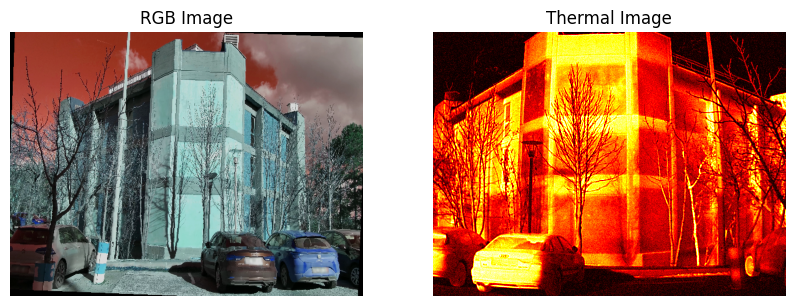

Processing condition: cloudy
Condition: cloudy, Visible Image Shape: torch.Size([8, 480, 640, 3]), Thermal Image Shape: torch.Size([8, 1, 480, 640])


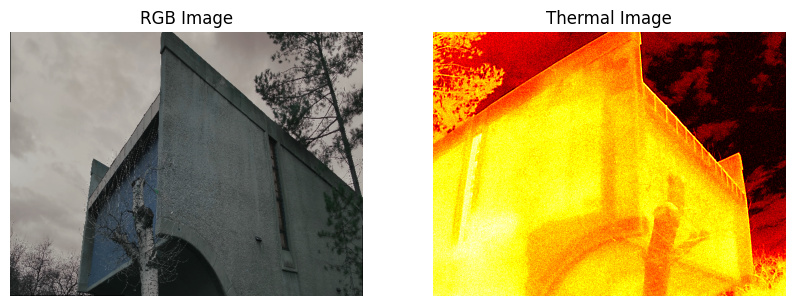

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def visualize_pair(rgb, thermal):
    """
    Visualize an RGB and thermal image pair.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(thermal.squeeze(0).numpy(), cmap="hot")
    plt.title("Thermal Image")
    plt.axis("off")
    plt.show()

# Define the base directory of the dataset
base_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR"

# List all conditions dynamically (e.g., `cloudy`, `sunny`) and exclude invalid directories
conditions = [
    condition for condition in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, condition)) and condition not in ['index']
]

# Iterate over each condition
dataloaders = {}
for condition in conditions:
    print(f"Processing condition: {condition}")

    # Initialize the dataset for the current condition
    try:
        dataset = ThermalRGBDataset(
            base_dir=base_dir,
            condition=condition,
            img_size=(640, 480),  # Resize to 640x480
            augment=True,         # Enable augmentation
            transform=None        # PyTorch transformations, if needed
        )

        # Create a DataLoader for the current condition
        dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
        dataloaders[condition] = dataloader  # Save DataLoader for later use

        # Optionally: Visualize a sample from each condition
        for visible_img, thermal_img in dataloader:
            print(f"Condition: {condition}, Visible Image Shape: {visible_img.shape}, Thermal Image Shape: {thermal_img.shape}")
            visualize_pair(visible_img[0], thermal_img[0])  # Visualize the first pair
            break

    except FileNotFoundError as e:
        print(f"Skipping condition {condition}: {e}")

### Data Augmentation

We will apply three augmentation techniques:
1. Random Hue, Saturation, and Value (HSV) Adjustment
2. Conversion to Grayscale
3. Cosine Transformation
4. Gaussian Blur

As for the final step, we will create the pipeline to apply the techniques mentioned above.

In [ ]:
# Define paths
input_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR"
output_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Augmentation functions
def adjust_hsv(image):
    """Adjust hue, saturation, and value of the image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue_adjust = np.random.uniform(-10, 10)
    sat_scale = np.random.uniform(0.8, 1.2)
    val_scale = np.random.uniform(0.8, 1.2)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue_adjust, 0, 180)  # Adjust hue
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)   # Scale saturation
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * val_scale, 0, 255)   # Scale value
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def convert_to_grayscale(image):
    """Convert RGB image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def cosine_transform(image):
    """Apply randomized cosine transformation to grayscale image."""
    image = image / 255.0  # Normalize to [0, 1]
    w0, wr, theta_r = 2 * np.pi / 3, np.pi / 2, np.pi / 2
    alpha0, alpha1 = np.random.normal(0, 0.1), np.random.normal(0, 0.1)
    w = w0 + abs(alpha0) * wr
    theta = np.pi / 2 + alpha1 * theta_r
    transformed = np.cos(w * (image - 0.5) + theta)
    transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())  # Normalize
    return (transformed * 255).astype(np.uint8)

def apply_gaussian_blur(image):
    """Apply Gaussian blur to smooth the image."""
    return cv2.GaussianBlur(image, (5, 5), 0)



The complete pipeline

In [ ]:
# Full augmentation pipeline
def augment_and_process(image):
    """
    Full pipeline for augmenting and preprocessing an image.
    Returns a dictionary of processed steps.
    """
    results = {}

    # Original image
    results["original"] = image

    # Step 1: Adjust HSV
    augmented_rgb = adjust_hsv(image)
    results["hsv_adjusted"] = augmented_rgb

    # Step 2: Convert to Grayscale
    grayscale_image = convert_to_grayscale(augmented_rgb)
    results["grayscale"] = grayscale_image

    # Step 3: Apply Cosine Transformation
    pseudo_thermal = cosine_transform(grayscale_image)
    results["cosine_transformed"] = pseudo_thermal

    # Step 4: Apply Gaussian Blur
    smoothed_thermal = apply_gaussian_blur(pseudo_thermal)
    results["gaussian_blurred"] = smoothed_thermal

    return results

### Download the augmented dataset to drive

In [ ]:
# Function to traverse dataset and apply the pipeline
def process_dataset(input_dir, output_dir):
    """
    Traverse the dataset folder structure, process images, and save augmented versions.
    """
    for root, dirs, files in os.walk(input_dir):
        # Recreate the folder structure in the output directory
        relative_path = os.path.relpath(root, input_dir)
        target_folder = os.path.join(output_dir, relative_path)
        os.makedirs(target_folder, exist_ok=True)

        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
                input_file_path = os.path.join(root, file)
                image = cv2.imread(input_file_path)
                if image is None:
                    print(f"Failed to load image: {input_file_path}")
                    continue

                # Convert BGR to RGB for processing
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply augmentation pipeline
                processed_images = augment_and_process(image)

                # Save augmented images
                for key, img in processed_images.items():
                    output_file_name = f"{os.path.splitext(file)[0]}_{key}.jpg"
                    output_file_path = os.path.join(target_folder, output_file_name)

                    if len(img.shape) == 2:  # Grayscale images
                        cv2.imwrite(output_file_path, img)
                    else:  # RGB images
                        cv2.imwrite(output_file_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

                print(f"Processed and saved: {input_file_path}")

!!! do not run this code, the augmented dataset is already uploaded in the drive

In [ ]:
# Run the pipeline
process_dataset(input_dir, output_dir)

Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_09654.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_09746.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_09845.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_09901.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_09950.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_10013.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_10077.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_10108.jpg
Processed and saved: /content/drive/MyDrive/ThermalNet/METU_VisTIR/sunny/scene_4/thermal/images/IM_10186.jpg
Processed and saved

Inspecting augmentations for: IM_00696_hsv


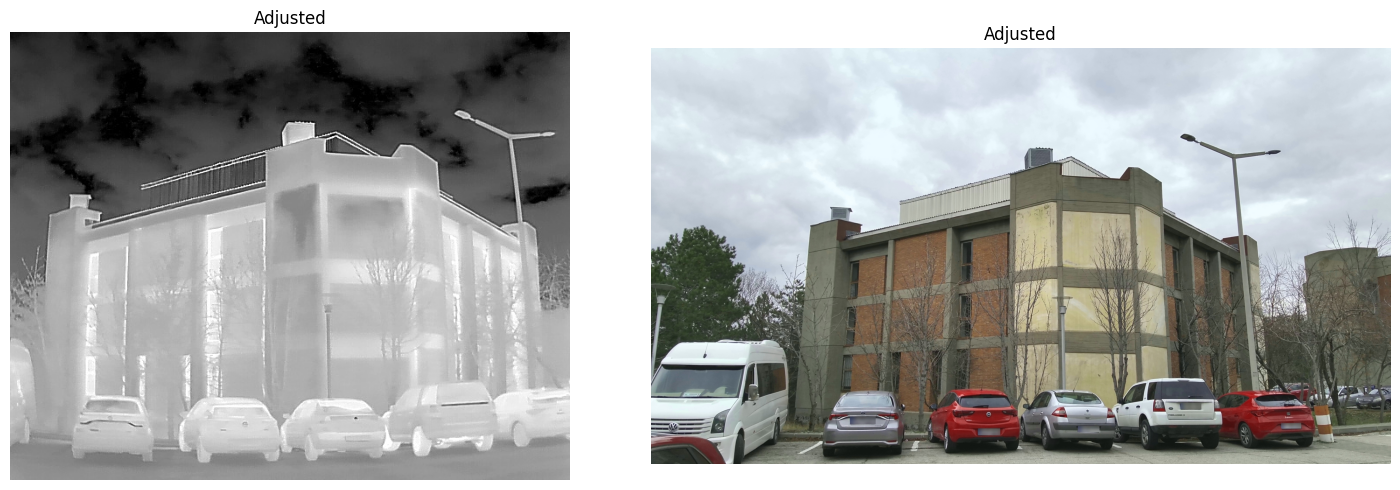

Inspecting augmentations for: IM_03699_gaussian


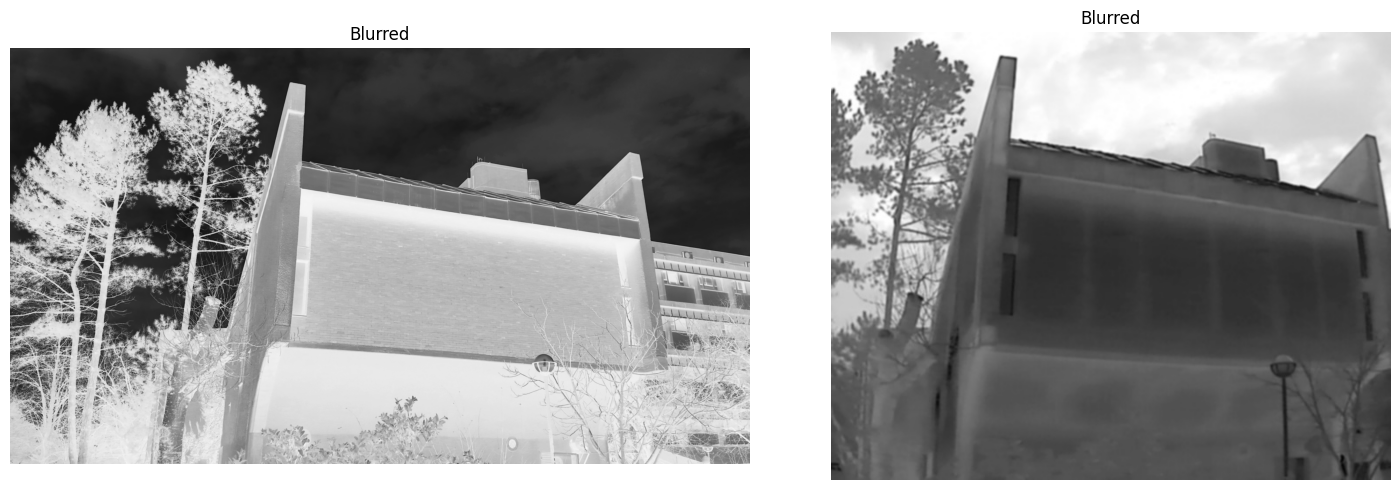

Inspecting augmentations for: IM_00695


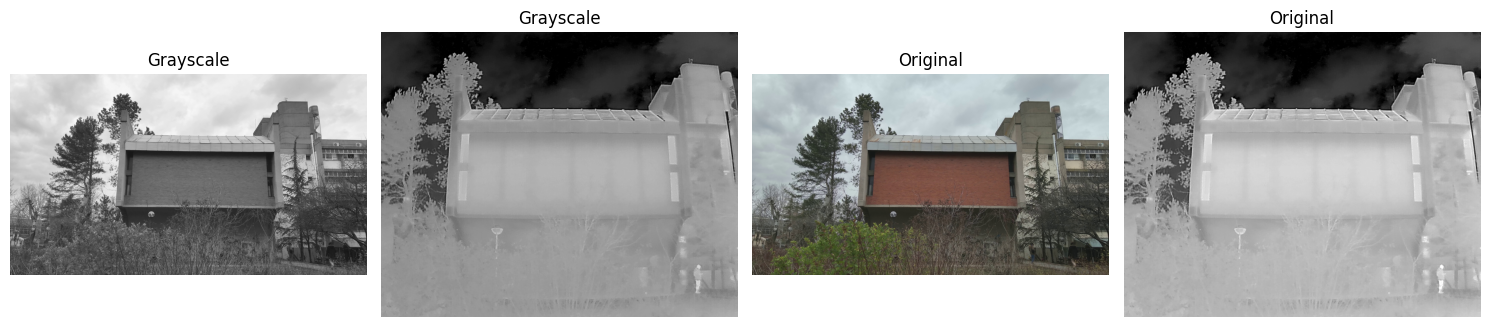

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def inspect_augmentations(augmented_folder, num_samples=5):
    """
    Visually inspect augmented images by displaying a few examples with their augmentations.

    Args:
        augmented_folder (str): Path to the folder containing augmented images.
        num_samples (int): Number of random samples to inspect.
    """
    # Recursively collect all augmented images
    all_files = []
    for root, _, files in os.walk(augmented_folder):
        all_files.extend([os.path.join(root, f) for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])

    if not all_files:
        print(f"No augmented images found in the folder: {augmented_folder}")
        return

    # Group images by their base name
    augmentation_dict = {}
    for file in all_files:
        base_name = "_".join(os.path.basename(file).split("_")[:-1])  # Extract the base name
        if base_name not in augmentation_dict:
            augmentation_dict[base_name] = []
        augmentation_dict[base_name].append(file)

    # Select random samples for inspection
    inspected_samples = list(augmentation_dict.keys())
    if len(inspected_samples) > num_samples:
        inspected_samples = random.sample(inspected_samples, num_samples)

    for base_name in inspected_samples:
        print(f"Inspecting augmentations for: {base_name}")
        augmented_images = augmentation_dict[base_name]

        # Sort by augmentation type for consistent visualization
        augmented_images.sort(key=lambda x: os.path.basename(x).split("_")[-1])

        # Display the original and augmented images
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(augmented_images):
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Get augmentation label
            aug_label = os.path.basename(img_path).split("_")[-1].split(".")[0]

            plt.subplot(1, len(augmented_images), i + 1)
            plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
            plt.title(aug_label.replace("_", " ").capitalize())
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Example usage
augmented_folder = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"
inspect_augmentations(augmented_folder, num_samples=3)

## Training Module